In [ ]:
# todo: this is completly broken, a starting point for starting over is 
# Untitler-3-all.py (16+11+11=38p)
# 3-head.py (19+0+2=21p)

# watch editorial
# also properly do dataset augmentation + proper model

In [35]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights

from tqdm import tqdm

In [36]:
seed = 123
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# change to the actual path
images_path = "E:\\IOAI\\nitro-nlp-25"

# Data preparation

In [37]:
class DuckDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.root_dir = root_dir
        self.df = self.prep_df(csv_file)
        self.target_size = (224, 224)
        # Color jitter object
        self.jitter = transforms.ColorJitter(
            brightness=0.5, contrast=0.5, saturation=0.5
        )

    def prep_df(self, csv_file):
        df = pd.read_csv(csv_file)
        df["BoundingBox"] = (
            df["BoundingBox"].str.split().apply(lambda x: list(map(float, x)))
        )
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row.iloc[0]
        img_path = os.path.join(self.root_dir, f"{filename}.png")
        image = Image.open(img_path).convert("RGB")
        orig_w, orig_h = image.size

        # Original bbox
        x1, y1, x2, y2 = row["BoundingBox"]

        # Resize image and scale bbox
        image = image.resize(self.target_size, resample=Image.BILINEAR)
        scale_x = self.target_size[0] / orig_w
        scale_y = self.target_size[1] / orig_h
        x1, x2 = x1 * scale_x, x2 * scale_x
        y1, y2 = y1 * scale_y, y2 * scale_y
        bbox = [x1, y1, x2, y2]

        # Random horizontal flip
        if np.random.rand() < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            W, H = self.target_size
            x1, y1, x2, y2 = bbox
            bbox = [W - x2, y1, W - x1, y2]

        # Random vertical flip
        if np.random.rand() < 0.5:
            image = image.transpose(Image.FLIP_TOP_BOTTOM)
            W, H = self.target_size
            x1, y1, x2, y2 = bbox
            bbox = [x1, H - y2, x2, H - y1]

        # Color jitter
        image = self.jitter(image)
        # To tensor
        image = transforms.ToTensor()(image)

        # Prepare labels
        has_duck = torch.tensor([row["DuckOrNoDuck"]], dtype=torch.float32)
        pixel_count = torch.tensor([row["PixelCount"]], dtype=torch.float32)
        bbox_tensor = torch.tensor(bbox, dtype=torch.float32)
        labels = torch.cat((has_duck, pixel_count, bbox_tensor))
        return image, labels

In [38]:
train_dataset = DuckDataset(
    csv_file='train_data.csv',
    root_dir=f'{images_path}\\train_dataset'
)

In [39]:
total_size = len(train_dataset)
val_size = int(0.2 * total_size)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(
    train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

# EDA

tensor([1.0000e+00, 4.2510e+03, 1.4534e+02, 1.1001e+02, 2.1374e+02, 1.9208e+02])


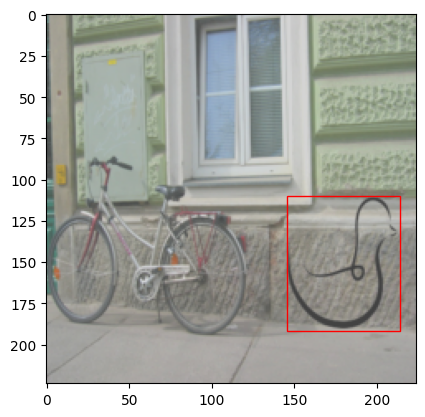

In [40]:
import matplotlib.patches as patches

sample, labels = next(iter(train_dataset))
sample = sample.permute(1, 2, 0)
print(labels)
fig, ax = plt.subplots()

ax.imshow(sample)

rect = patches.Rectangle(
    (labels[2], labels[3]),
    labels[4] - labels[2],
    labels[5] - labels[3],
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)
ax.add_patch(rect)

# Model selection

In [41]:
class DuckNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Classification backbone
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone.fc = nn.Sequential(
            nn.Linear(self.backbone.fc.in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.detect_duck = nn.Linear(128, 1)
        self.count_pixels = nn.Linear(128, 1)
        # Faster R-CNN for bbox detection
        self.detector = fasterrcnn_mobilenet_v3_large_fpn(
            weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT,
            box_predictor=None,
        )

    def forward(self, images):
        # Extract deep features
        feats = self.backbone(images)
        # Duck presence logits (raw)
        logits = self.detect_duck(feats).squeeze(1)

        # Determine per-image mask: has_duck = sigmoid(logit) >= 0.5
        probs = torch.sigmoid(logits)
        has_duck_mask = probs >= 0.5

        # Pixel count: only for images predicted as duck
        raw_counts = self.count_pixels(feats).squeeze(1)
        pixel_counts = torch.zeros_like(raw_counts)
        pixel_counts[has_duck_mask] = raw_counts[has_duck_mask]

        # Detection: run R-CNN on all images, then mask boxes
        # Put detector in eval/inference
        self.detector.eval()
        with torch.no_grad():
            dets = self.detector(images)
        # Collect one box per image
        boxes = []
        for i, det in enumerate(dets):
            if has_duck_mask[i] and len(det.get("boxes", [])) > 0:
                # pick highest score
                idx = det["scores"].argmax()
                box = det["boxes"][idx]
            else:
                # no duck: zero box
                box = torch.zeros(4, device=images.device)
            boxes.append(box)
        bbox_tensor = torch.stack(boxes, dim=0)

        # Build final tensor: [logit, count, x1, y1, x2, y2]
        out = torch.cat(
            [logits.unsqueeze(1), pixel_counts.unsqueeze(1), bbox_tensor], dim=1
        )
        return out

model = DuckNet().to(device)

In [42]:
# sanity check
sample, labels = next(iter(train_dataset))
sample = sample.unsqueeze(0) # batch dim
model(sample.to(device))

tensor([[7.8415e-02, 4.0585e-02, 3.4508e+00, 8.3378e+01, 1.2072e+02, 1.9494e+02]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [43]:
def get_loss(outputs, targets):
    loss_duckornoduck  = F.binary_cross_entropy_with_logits(outputs[:, 0], targets[:, 0])
    loss_pixelcnt = torch.sqrt(F.mse_loss(outputs[:, 1], targets[:, 1]))
    loss_boundingbox = F.mse_loss(outputs[:, 2:], targets[:, 2:])

    loss = loss_duckornoduck + loss_pixelcnt + loss_boundingbox
    return loss


optimizer = optim.AdamW(model.parameters(), lr=1e-5)

In [44]:
loss_values = []

In [45]:
num_epochs = 1
for epoch in range(num_epochs):
    # training
    model.train()
    train_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, labels in pbar:
        images, targets = images.to(device), labels.to(device)

        # forward pass
        optimizer.zero_grad()
        outputs = model(images)

        loss = get_loss(outputs, targets)

        # backward pass
        loss.backward()
        optimizer.step()

        # stats for nerds
        loss_values.append(loss.item())
        train_loss += loss.item() * images.size(0)
    train_loss /= train_size

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f"Val Epoch {epoch+1}/{num_epochs}"):
            images, targets = images.to(device), targets.to(device)

            outputs = model(images)
            loss = get_loss(outputs, targets)

            val_loss += loss.item() * images.size(0)
    val_loss /= val_size

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

Val Epoch 1/1: 100%|██████████| 23/23 [00:14<00:00,  1.64it/s]

Epoch 1/1 - Train Loss: 10249.8157 - Val Loss: 9847.5299


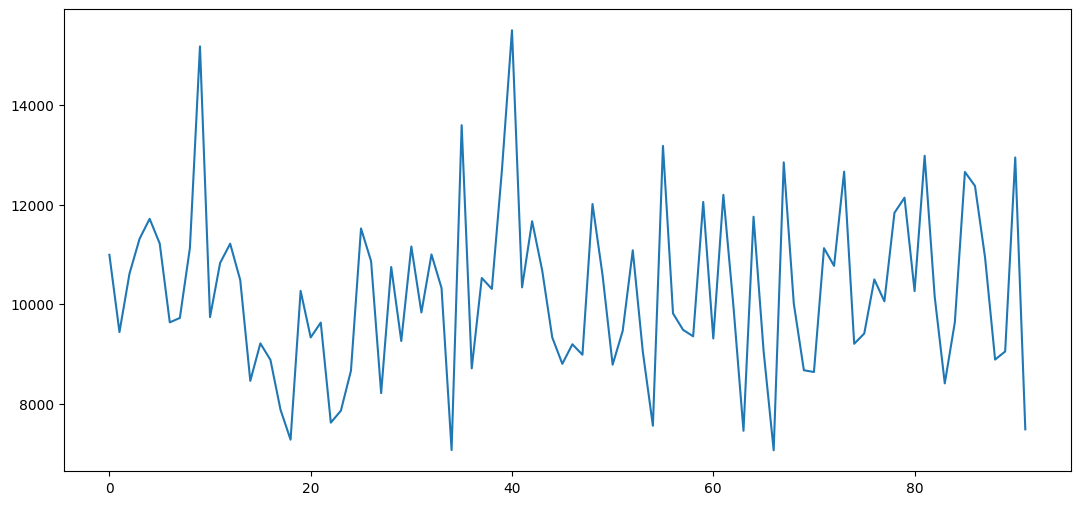

In [46]:
plt.figure(figsize=(13, 6))
plt.plot(loss_values)

# Submission

In [47]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.files = [f for f in os.listdir(root_dir) if f.lower().endswith(".png")]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        path = os.path.join(self.root_dir, fname)
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        base = os.path.splitext(fname)[0]
        return image, base


test_dataset = TestDataset(
    root_dir=f"{images_path}\\test_dataset",
    transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    ),
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [48]:
model.eval()
subtask1 = []
subtask2 = []
subtask3 = []

with torch.no_grad():
    for images, bases in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        outputs = model(images).squeeze(1)

        for base, pred in zip(bases, outputs):
            # subtask 1: duck or no duck
            subtask1_answer = (F.sigmoid(pred[0]) >= 0.5)
            subtask1.append((1, base, int(subtask1_answer.item())))

            if subtask1 != 0:
                # subtask 2: pixel count
                subtask2.append((2, base, int(pred[1].item())))

                # subtask 3: bounding box
                box = [int(i.item()) for i in pred[2:]]
                subtask3_answer = f"{box[0]} {box[1]} {box[2]} {box[3]}"
                subtask3.append((3, base, subtask3_answer))
            else:
                subtask2.append((2, base, 0))
                subtask3.append((3, base, 0))

Testing:  81%|████████▏ | 26/32 [00:42<00:09,  1.62s/it]


KeyboardInterrupt: 

In [ ]:
subtask1 = pd.DataFrame(subtask1, columns=["subtaskID", "datapointID", "answer"])
subtask2 = pd.DataFrame(subtask2, columns=["subtaskID", "datapointID", "answer"])
subtask3 = pd.DataFrame(subtask3, columns=["subtaskID", "datapointID", "answer"])

In [ ]:
submission = pd.concat([subtask1, subtask2, subtask3], ignore_index=True)

submission.head()

,subtaskID,datapointID,answer
0,1,1,1
1,1,113,1
2,1,128,1
3,1,142,1
4,1,157,1


In [ ]:
submission.to_csv("submission.csv", index=False)